In [1]:
import os
from pathlib import Path

from torch.autograd import Variable
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import cv2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

import config as cfg

In [2]:
OUTPUT_PATH = "./Deeplabv3P_resnet50_batch16"
BASE_MODEL_NAME = OUTPUT_PATH + "/FP16"

IMAGE_WIDTH = 1600
IMAGE_HEIGHT = 800
DEVICE='cuda'

In [3]:
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

# Paths where PyTorch, ONNX and OpenVINO IR models will be stored.
model_path = Path(BASE_MODEL_NAME).with_suffix(".pth")
onnx_path = model_path.with_suffix(".onnx")
ir_path = model_path.with_suffix(".xml")

In [4]:
def normalize(image: np.ndarray, input_range=[0, 1], mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) -> np.ndarray:
    # image = image.astype(np.float32)
    # if input_range is not None:
    #     if image.max() > 1 and input_range[1] == 1:
    #         image = image / 255.0

    if mean is not None:
        mean = np.array(mean)
        image = image - mean

    if std is not None:
        std = np.array(std)
        image = image / (255 * std)
    return image

In [5]:
def preprocess_image(filename=None, num_randoms=10):
    def preprocess(filename):
        image_filename = os.path.join(cfg.INFERENCE_IMAGE_DIR, filename)
        image = cv2.cvtColor(cv2.imread(image_filename), cv2.COLOR_BGR2RGB)

        resized_image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        normalized_image = normalize(resized_image)

        # Convert the resized images to network input shape.
        input_image = np.expand_dims(np.transpose(resized_image, (2, 0, 1)), 0).astype(float)
        normalized_input_image = np.expand_dims(np.transpose(normalized_image, (2, 0, 1)), 0).astype(float)
        return resized_image, normalized_input_image
    
    if filename != None:
        return preprocess(filename)
    
    import random
    inference_images = os.listdir(cfg.INFERENCE_IMAGE_DIR)
    
    random_images = random.sample(inference_images, num_randoms)
    resized_images, normalized_images = [], []
    for img_name in random_images:
        r_img, norm_img = preprocess(img_name)
        resized_images.append(r_img)
        normalized_images.append(norm_img)
    
    return resized_images, normalized_images

In [6]:
def convert_image_shape_to_show(inputs):
    outputs = np.zeros((800, 1600, 3))
    outputs[...,0] = inputs
    outputs[...,1] = inputs
    outputs[...,2] = inputs
    outputs = cv2.resize(outputs, (1716, 942))
    return outputs

In [7]:
from time import time
def log_time(func):
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'{t2-t1}ms')
        return result
    return wrap_func

# Load the OpenVINO IR Network and Run Inference on the ONNX model

In [8]:
from openvino.runtime import Core

In [9]:
ie = Core()
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device, "FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: Intel(R) Core(TM) i7-9700 CPU @ 3.00GHz


In [10]:
# Load the network to OpenVINO Runtime.
def load_openvino_model(device_name="CPU"):
    t1 = time()
    ie = Core()
    t2 = time()
    print("initial time: {:.4f}ms".format(t2-t1))
    
    t1 = time()
    model_onnx = ie.read_model(model=onnx_path)
    t2 = time()
    print("read model time: {:.4f}ms".format(t2-t1))
    
    t1 = time()
    compiled_model = ie.compile_model(model=model_onnx, device_name=device_name)
    t2 = time()
    print("compile model time: {:.4f}ms".format(t2-t1))
    return compiled_model

In [11]:
def inference(compiled_model_onnx, normalized_image):
    output_layer_onnx = compiled_model_onnx.output(0)
    
    # Runinference on the input image.
    t1 = time()
    res_onnx = compiled_model_onnx([normalized_image])[output_layer_onnx]
    t2 = time()
    print("inference time: {:.4f}ms".format(t2-t1))
    # Convert the network result to a segmentation map and display the result.
    # result_mask_onnx = np.squeeze(np.argmax(res_onnx, axis=1)).astype(np.uint8)
    
    t1 = time()
    res_onnx = np.squeeze(res_onnx).round()
    t2 = time()
    print("process output time: {:.4f}ms".format(t2-t1))
    
    outputs = convert_image_shape_to_show(res_onnx)
    
    return outputs

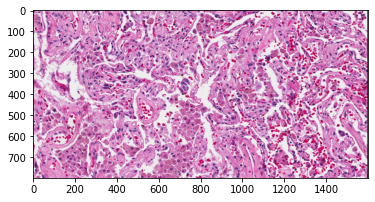

In [12]:
resized_image, normalized_image = preprocess_image("Private_00000045.jpg")
plt.imshow(resized_image)

initial time: 0.0013ms
read model time: 0.2338ms
compile model time: 0.1056ms
inference time: 0.5138ms
process output time: 0.0005ms


True

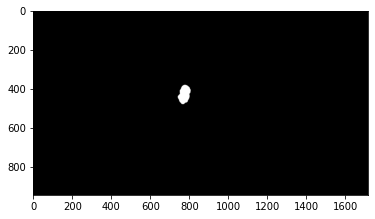

In [13]:
compiled_model = load_openvino_model()
outputs = inference(compiled_model, normalized_image)
plt.imshow(outputs)
cv2.imwrite("result.jpg", outputs)

# torch output

In [14]:
def torch_inference(best_model, normalized_image):
    
    best_model.eval()
    x_tensor = torch.from_numpy(normalized_image).to(DEVICE)
    
    with torch.no_grad():
        t1 = time()
        pr_mask = best_model(x_tensor.float())
        t2 = time()
        print("inference time: {:.4f}ms".format(t2-t1))
        
        t1 = time()
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        t2 = time()
        print("process output time: {:.4f}ms".format(t2-t1))
    
    mask = convert_image_shape_to_show(pr_mask)
    return mask

torch load model time: 2.6986ms
inference time: 0.0621ms
process output time: 0.0522ms


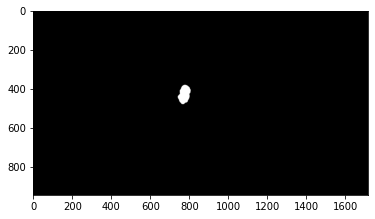

In [15]:
t1 = time()
best_model = torch.load(os.path.join(cfg.MODEL_DIR, "Deeplabv3P_resnet50_batch16.pth"))
t2 = time()
print("torch load model time: {:.4f}ms".format(t2-t1))

mask = torch_inference(best_model, normalized_image)
plt.figure()
plt.imshow(mask)

# Other Samples

In [16]:
resized_images, normalized_input_images = preprocess_image(num_randoms=10)

initial time: 0.0006ms
read model time: 0.0618ms
compile model time: 0.0720ms
inference time: 0.6191ms
process output time: 0.0006ms
inference time: 0.0107ms
process output time: 0.0309ms
inference time: 0.5340ms
process output time: 0.0006ms
inference time: 0.0103ms
process output time: 0.0303ms
inference time: 0.5349ms
process output time: 0.0008ms
inference time: 0.0692ms
process output time: 0.0608ms
inference time: 0.5433ms
process output time: 0.0006ms
inference time: 0.0107ms
process output time: 0.0692ms
inference time: 0.5473ms
process output time: 0.0008ms
inference time: 0.0106ms
process output time: 0.0647ms
inference time: 0.5432ms
process output time: 0.0006ms
inference time: 0.0114ms
process output time: 0.0643ms
inference time: 0.5338ms
process output time: 0.0005ms
inference time: 0.0107ms
process output time: 0.0637ms
inference time: 0.5357ms
process output time: 0.0004ms
inference time: 0.0105ms
process output time: 0.0613ms
inference time: 0.5298ms
process output ti

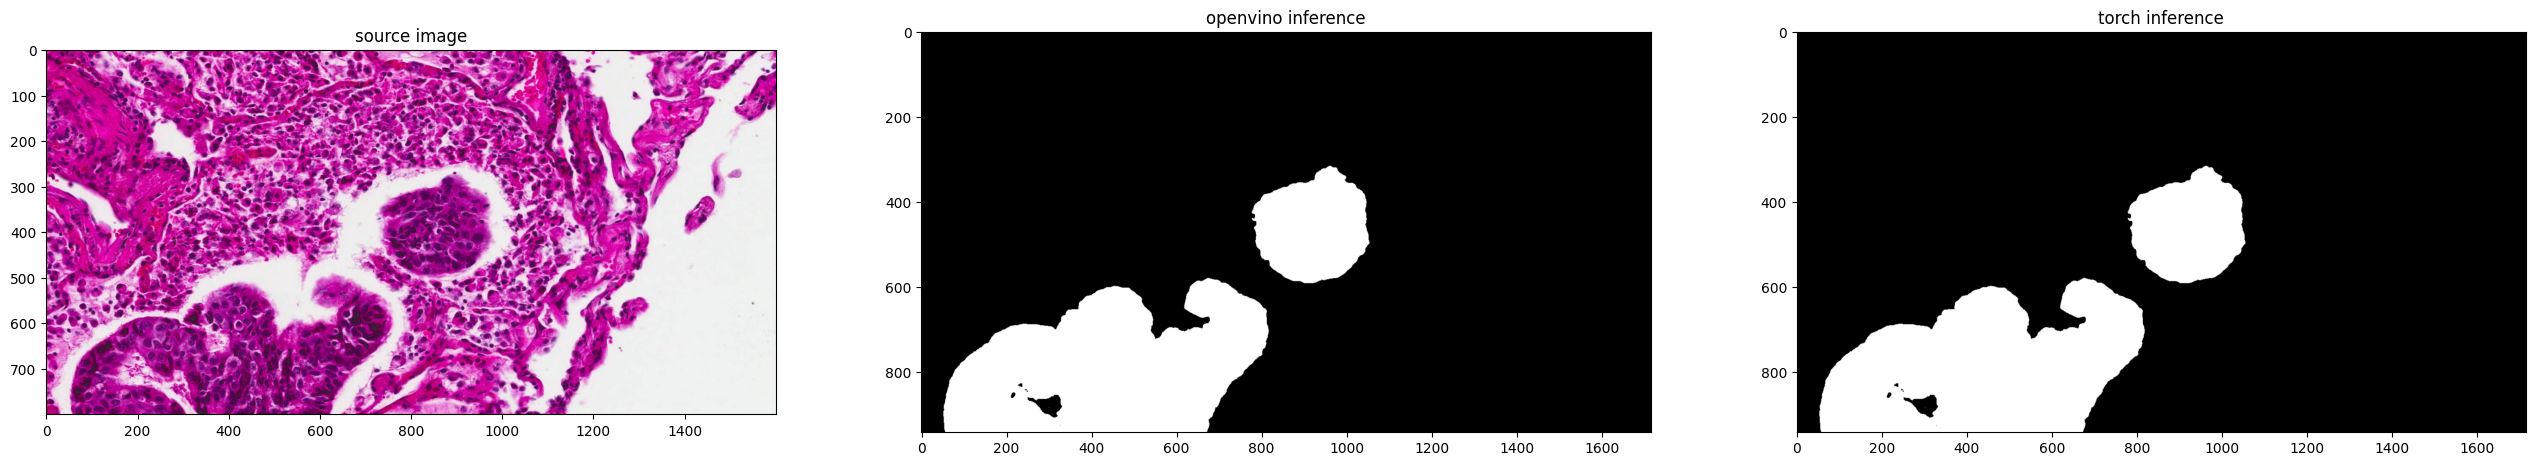

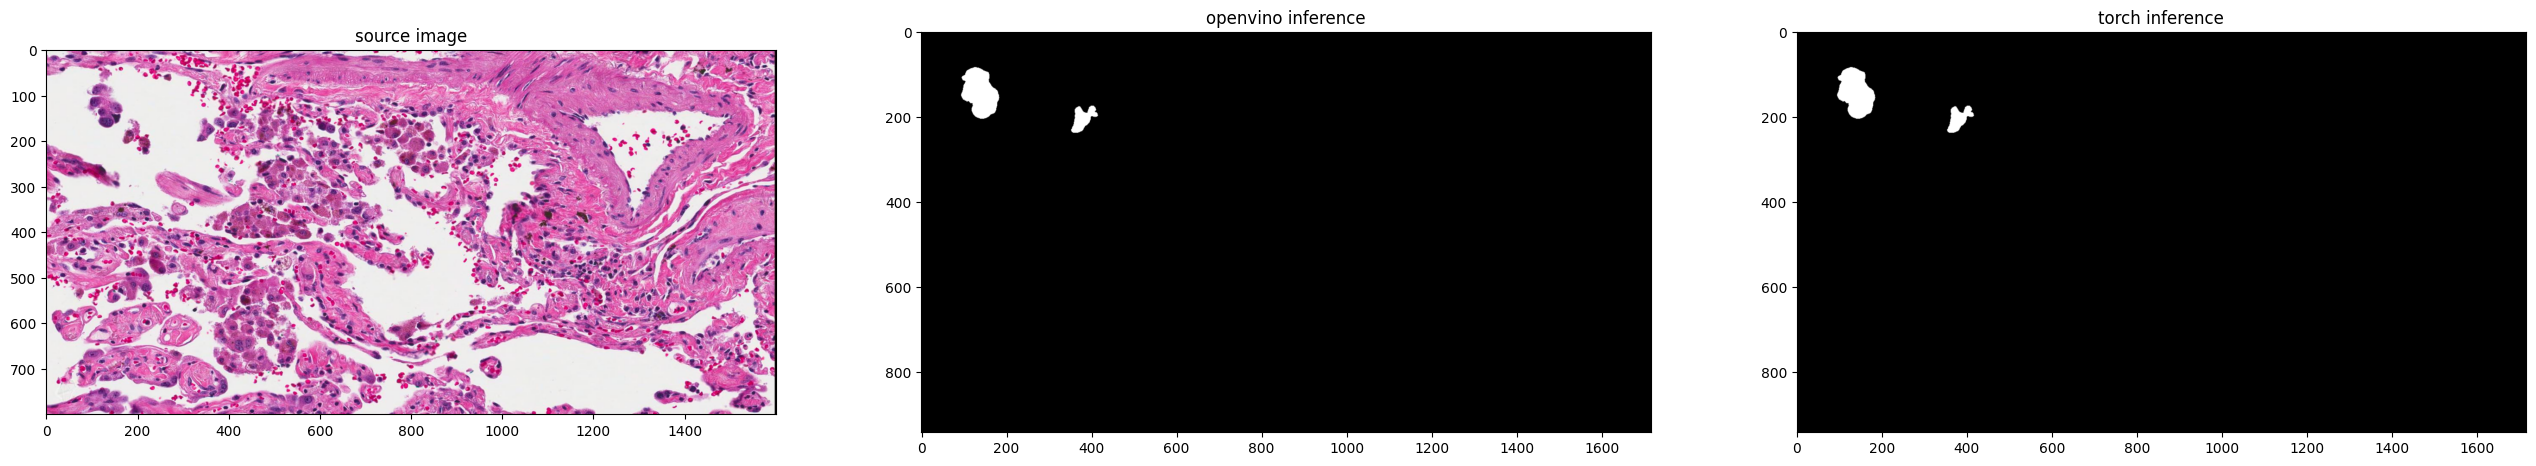

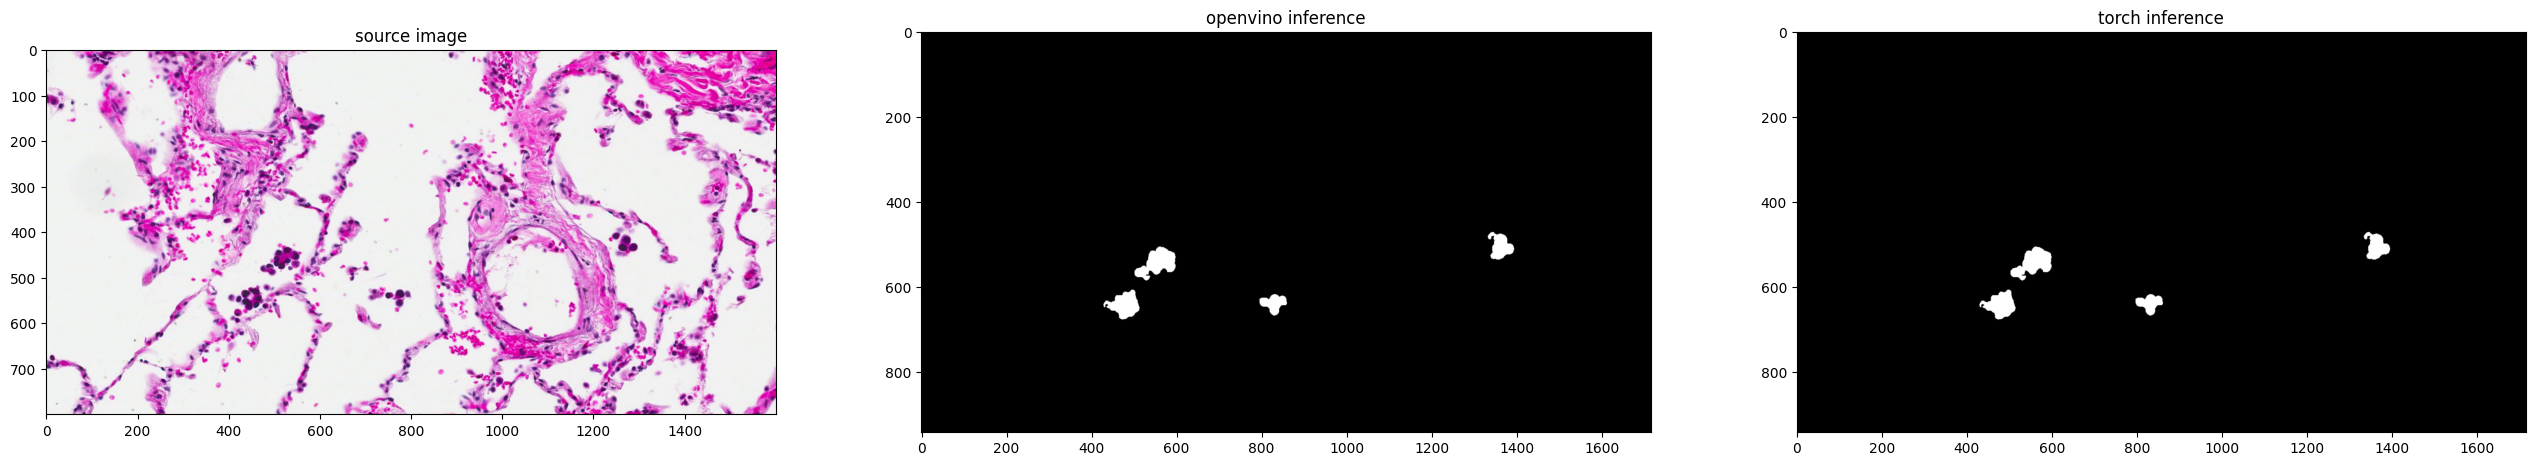

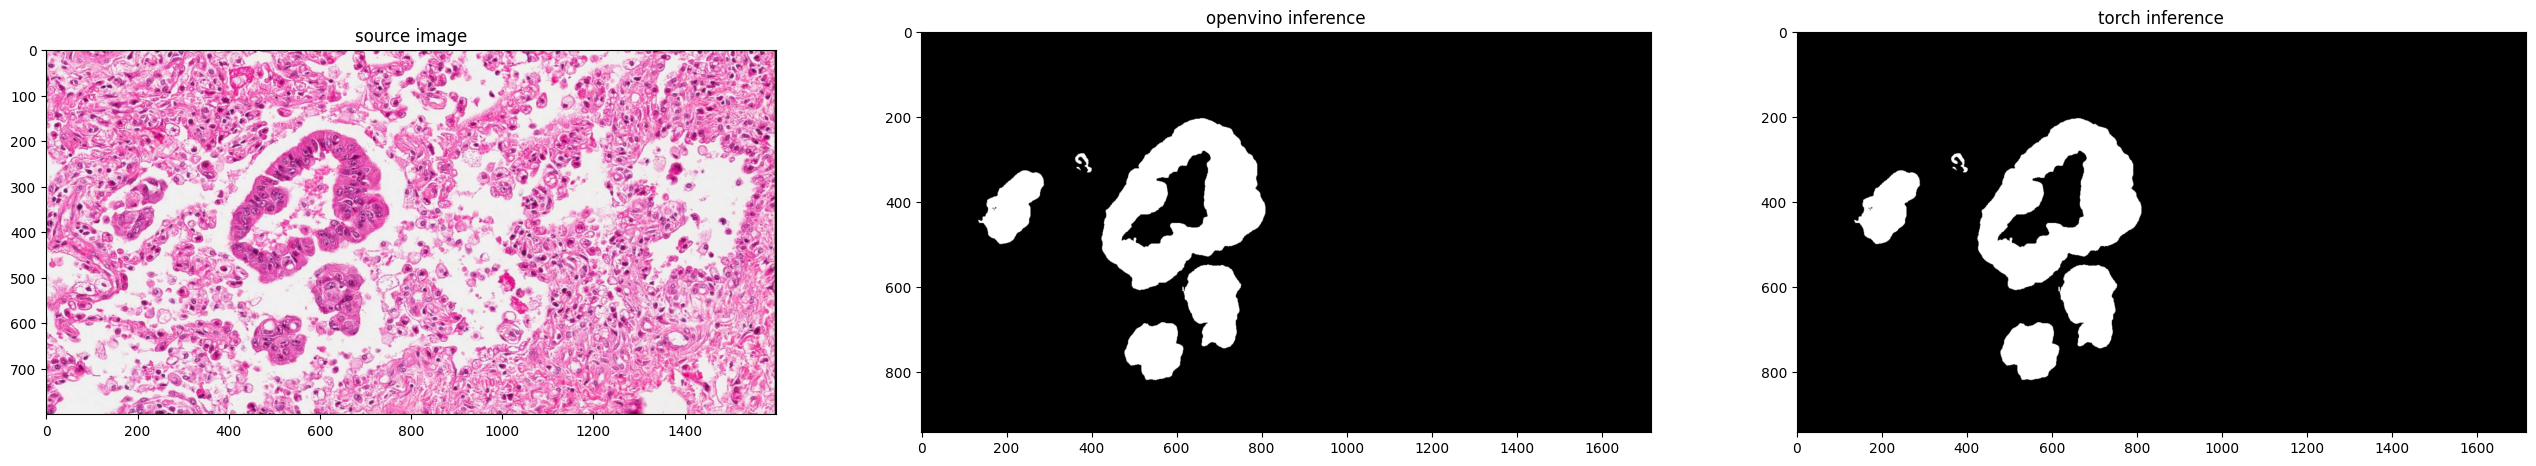

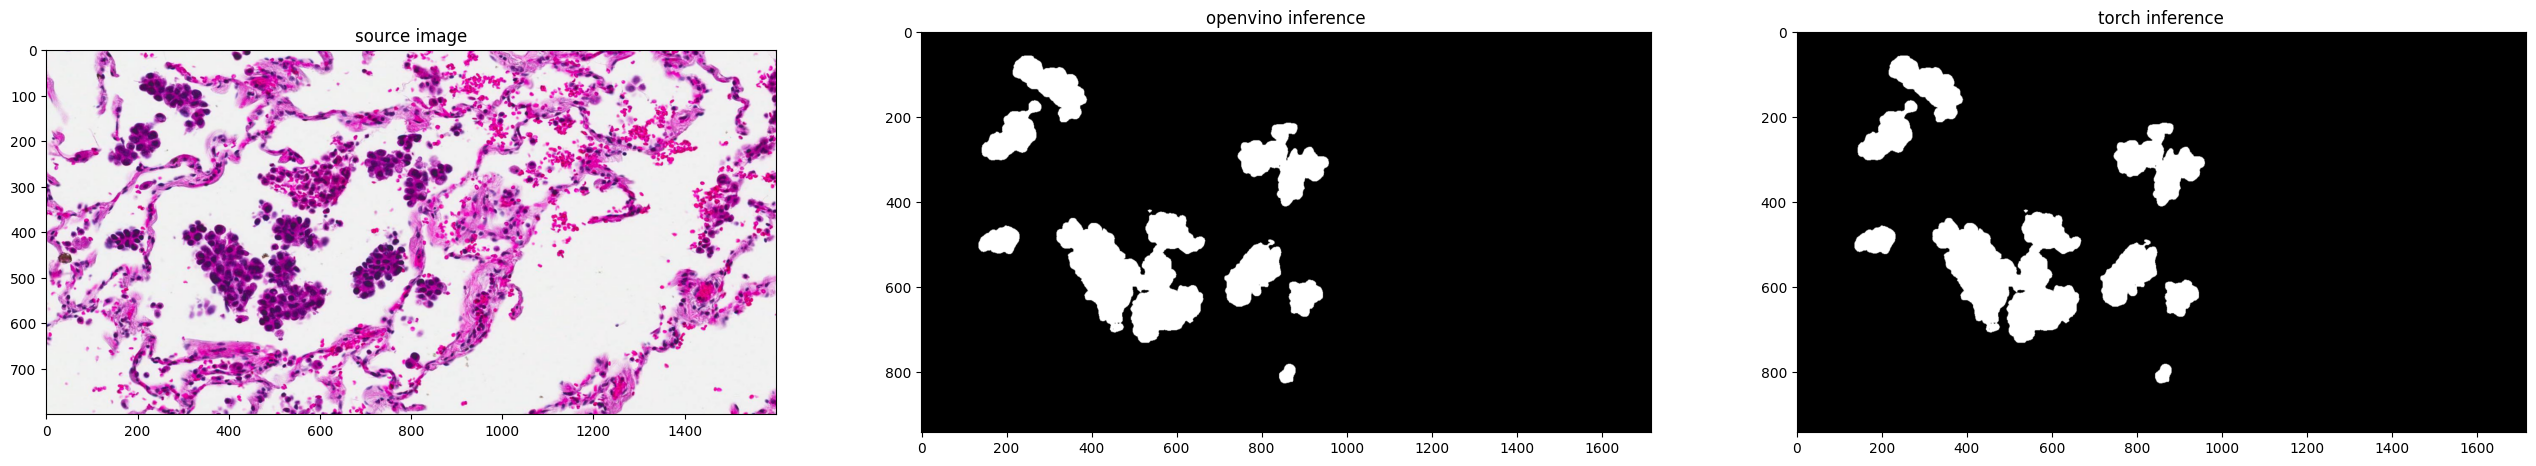

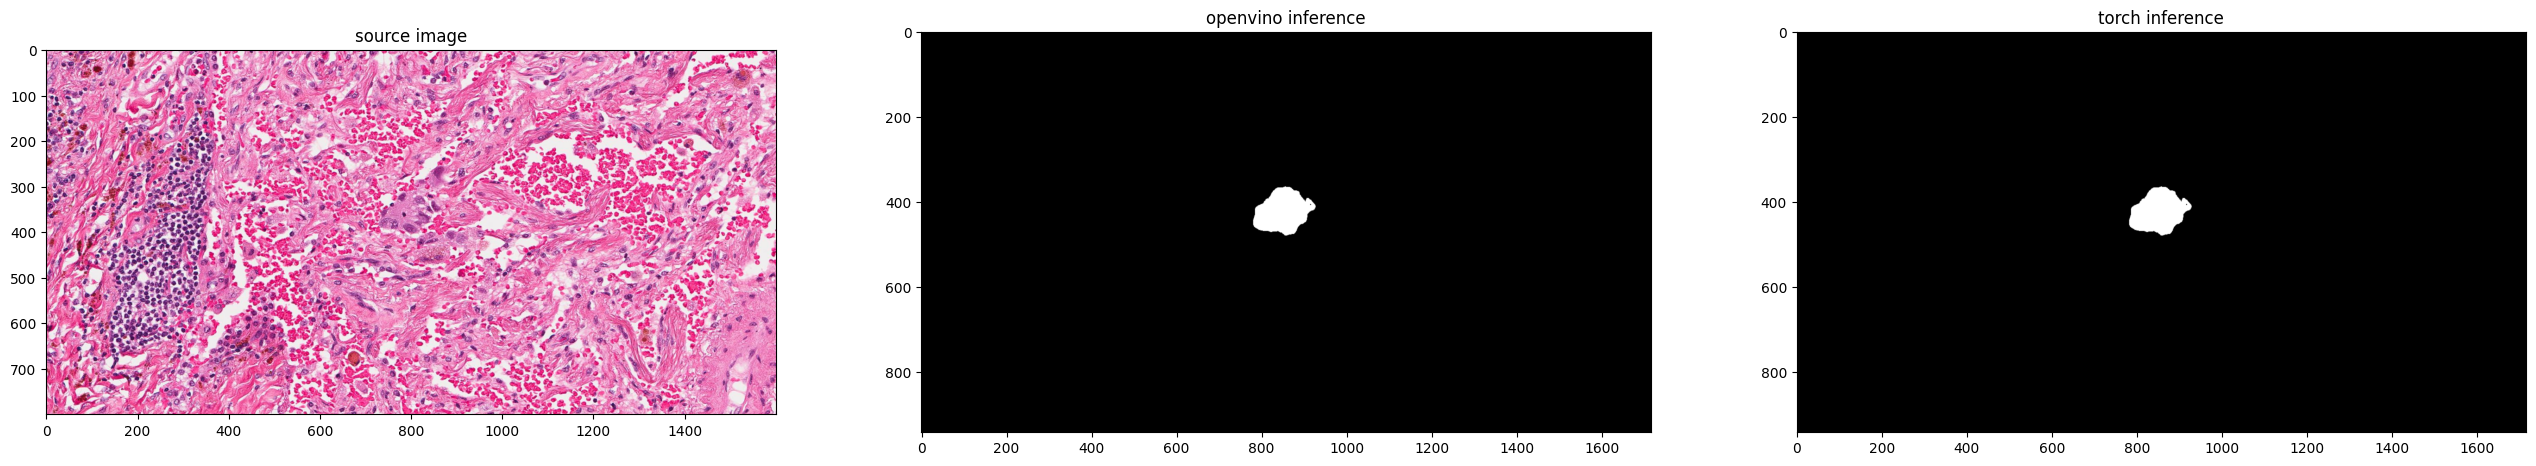

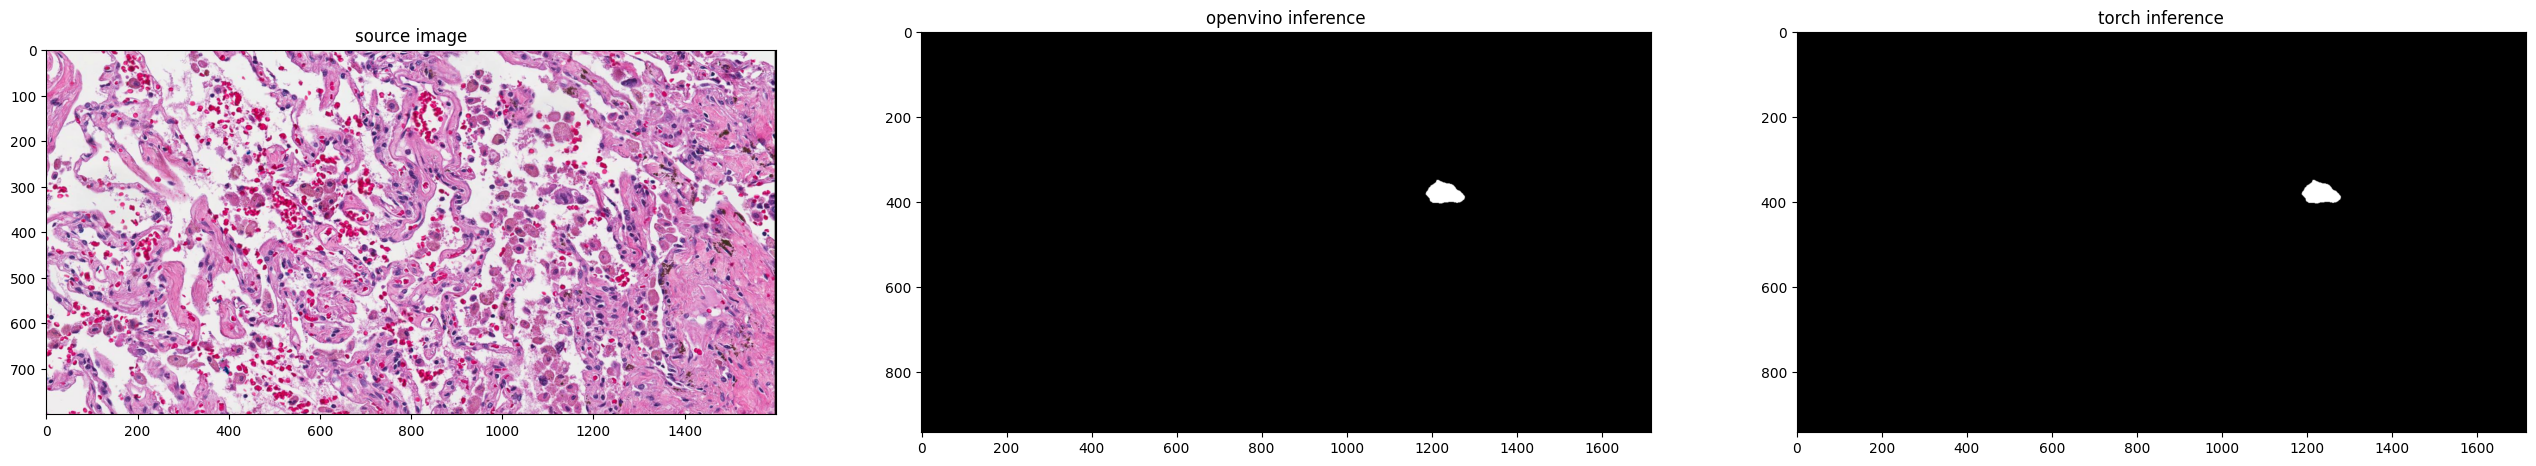

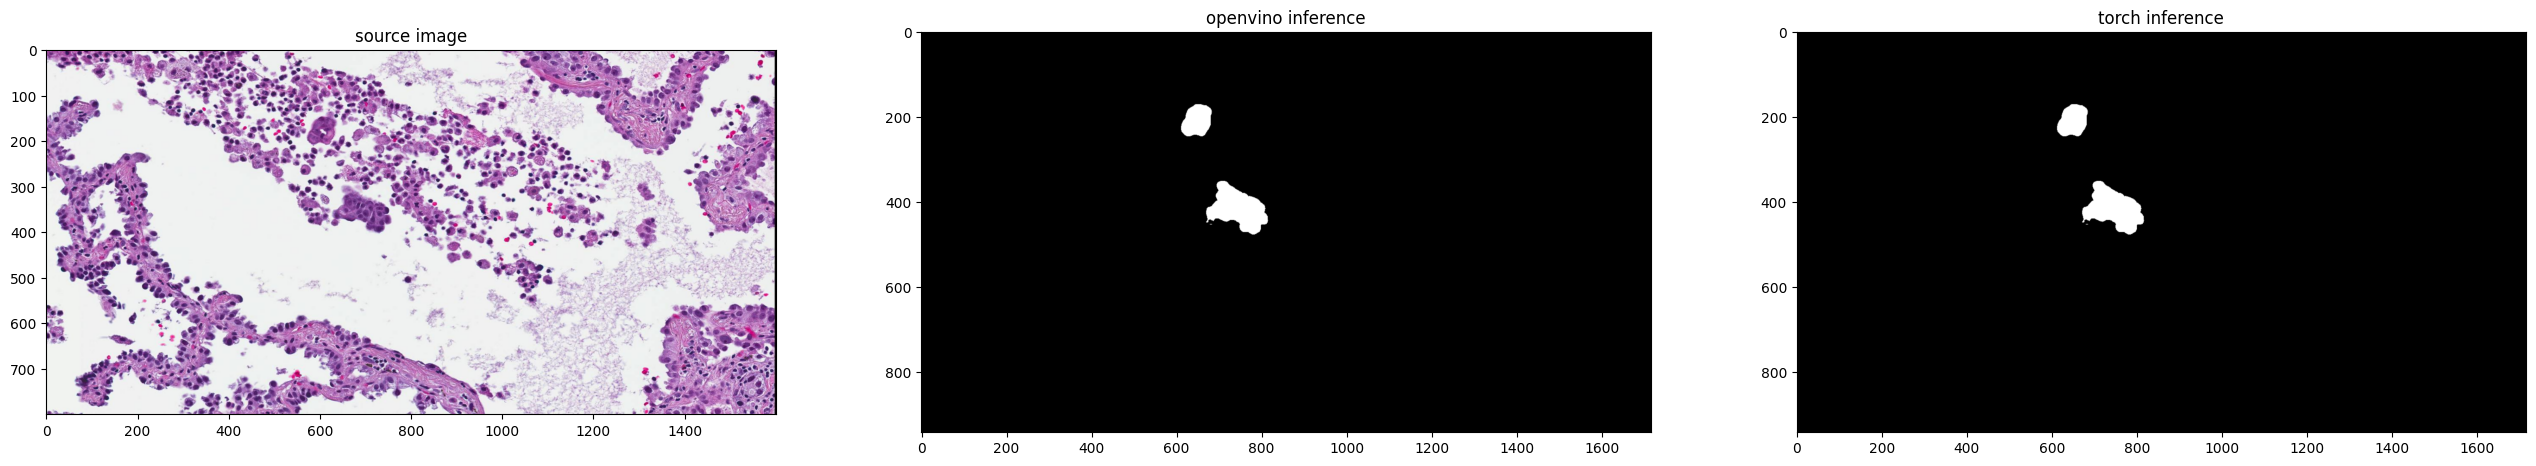

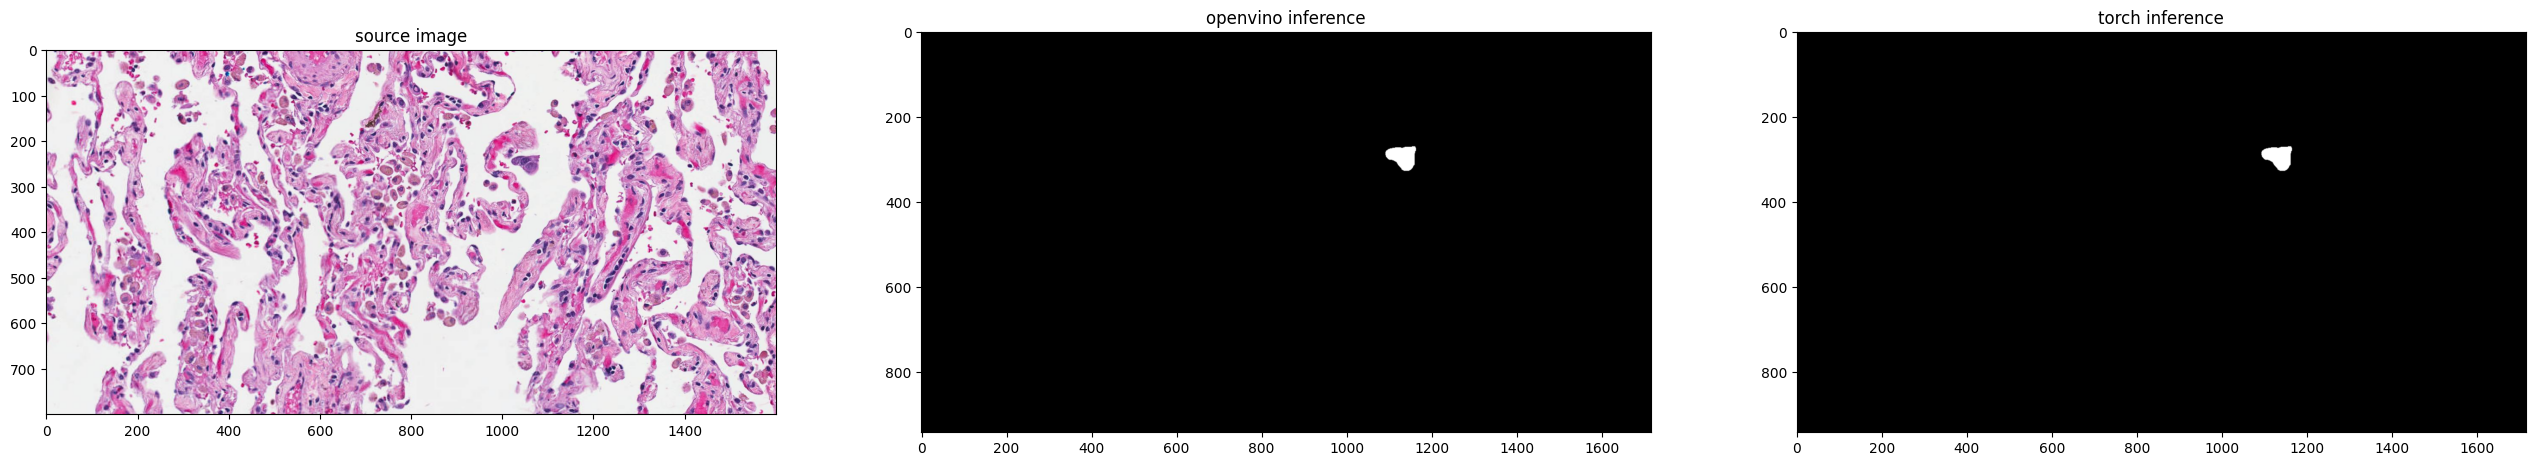

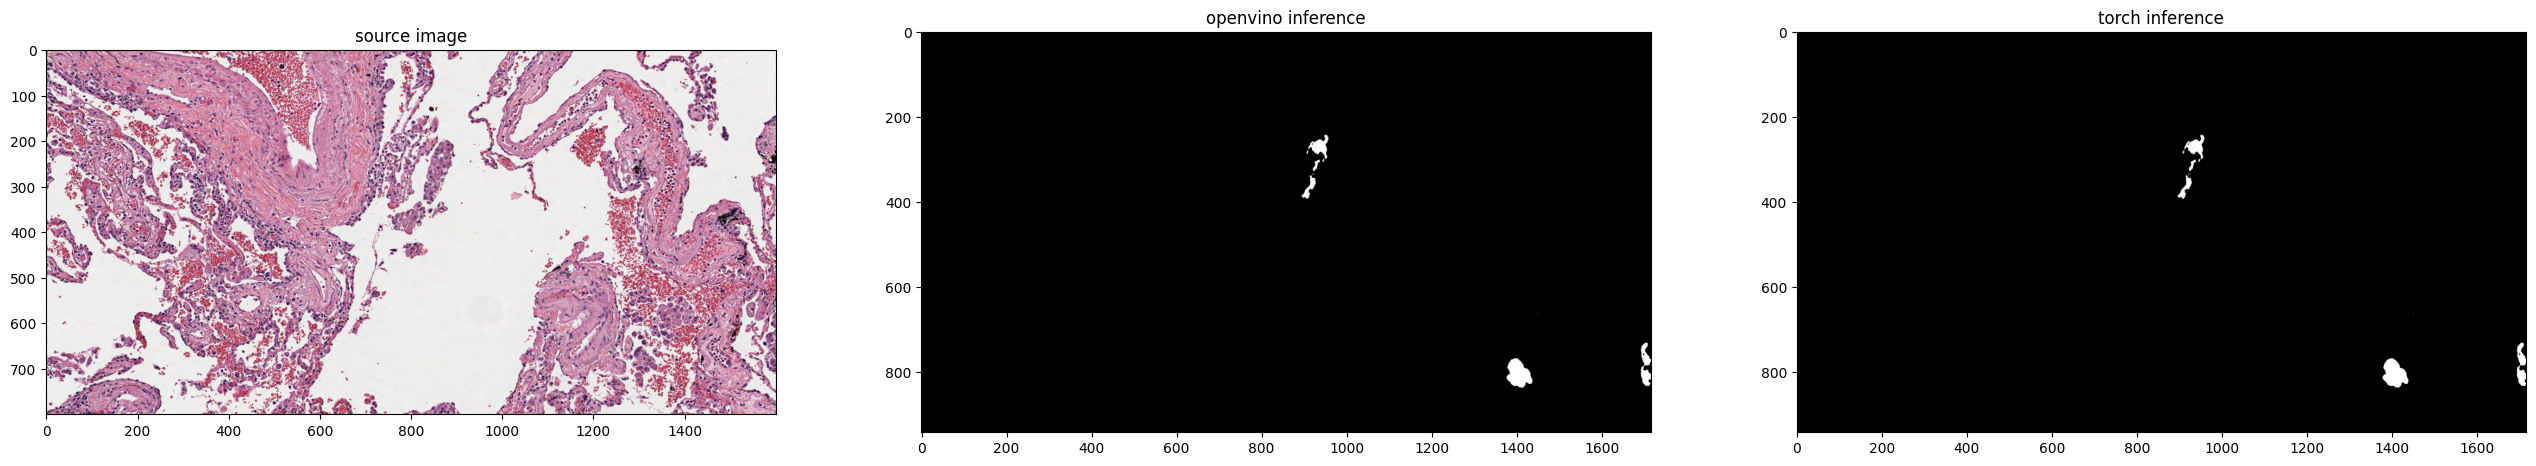

In [17]:
cpu_model = load_openvino_model()
# gpu_model = load_openvino_model(device_name="GPU")
best_model = torch.load(os.path.join(cfg.MODEL_DIR, "Deeplabv3P_resnet50_batch16.pth"))

for r_img, norm_img in zip(resized_images, normalized_input_images):
    fig = plt.figure(figsize=(32, 32))
    ax1 = fig.add_subplot(131)
    ax1.set_title("source image")
    ax1.imshow(r_img)
    
    openvino_mask = inference(cpu_model, norm_img)
    ax2 = fig.add_subplot(132)
    ax2.set_title("openvino inference")
    ax2.imshow(openvino_mask)
    
    torch_mask = torch_inference(best_model, norm_img)
    ax3 = fig.add_subplot(133)
    ax3.set_title("torch inference")
    ax3.imshow(openvino_mask)

# PrepostProcessor

In [63]:
from openvino.preprocess import PrePostProcessor, ResizeAlgorithm, ColorFormat
from openvino.runtime import Core, Layout, Type

In [81]:
image_filename = os.path.join(cfg.INFERENCE_IMAGE_DIR, "Private_00000045.jpg")
image = cv2.imread(image_filename)
input_tensor = np.expand_dims(image, 0)

ie = Core()
model = ie.read_model(model=ir_path)

ppp = PrePostProcessor(model)
_, h, w, _ = input_tensor.shape

ppp.input().tensor().set_layout(Layout('NHWC')).set_spatial_static_shape(h, w).set_color_format(ColorFormat.BGR)
ppp.input().preprocess().convert_color(ColorFormat.RGB).resize(ResizeAlgorithm.RESIZE_LINEAR, IMAGE_HEIGHT, IMAGE_WIDTH).mean([0.485, 0.456, 0.406]).scale([255 * 0.229, 255 * 0.224, 255 * 0.225])

ppp.input().model().set_layout(Layout('NCHW'))
# ppp.output().tensor().set_element_type(Type.f32)

model = ppp.build()
compiled_model = ie.compile_model(model, 'AUTO')
results = compiled_model.infer_new_request({0: input_tensor})
probs = next(iter(results.values()))

print(probs.shape)

(1, 1, 800, 1600)


In [82]:
res_onnx = np.squeeze(probs).round()
outputs = convert_image_shape_to_show(res_onnx)

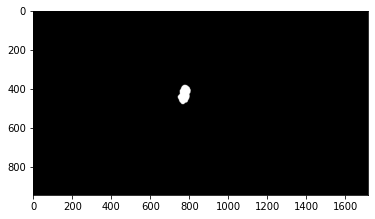

In [83]:
plt.imshow(outputs)